# **Project I**

###### - Team Members: Karen Lin, Kevin Zhang, Sunjae Youm </br> - 6/17/2024 </br> - Data Source: https://catalog.data.gov/dataset/crash-reporting-drivers-data/resource/9851a37f-4f32-464e-8ba6-c23023653a7f

### **Abstract**
Our data team assumed that we received a request from the Montgomery County local government in Maryland. The purpose of the request was to determine how to use the county budget to improve traffic and reduce car accidents. Additionally, Montgomery County wanted to choose a specific municipality and asked us, as data analysts, to identify which roads had the most car accidents. To achieve this, we investigated traffic accident records from January 2015 to March 2024, analyzing the areas with the highest accident rates, the time periods with the most accidents, and whether there were traffic control regulations in place at the accident locations.

In [1]:
# Dependencies

import pandas as pd
import numpy as np
import requests
import json
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the car_crash_drivers_report
car_crash_df = pd.read_csv("./Resources/Crash_Reporting_-_Drivers_Data.csv")
car_crash_df.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,EJ78850038,230034791,Gaithersburg Police Depar,Property Damage Crash,07/21/2023 05:59:00 PM,Maryland (State),FREDERICK RD,Unknown,WATKINS MILL RD,NaN,...,40,No,No,2011,GMC,TK,NO MISUSE,39.159264,-77.219025,"(39.1592635, -77.21902483)"
2,MCP2009002G,230034583,Montgomery County Police,Property Damage Crash,07/20/2023 03:10:00 PM,Maryland (State),GEORGIA AVE,Maryland (State),NORBECK RD,NaN,...,35,No,No,2019,FORD,F150,NO MISUSE,39.109535,-77.075806,"(39.10953506, -77.07580619)"
3,MCP3201004C,230035036,Montgomery County Police,Property Damage Crash,07/23/2023 12:10:00 PM,County,CRYSTAL ROCK DR,County,WATERS LANDING DR,NaN,...,40,No,No,2016,KIA,SW,NO MISUSE,39.190149,-77.266766,"(39.19014917, -77.26676583)"
4,MCP23290028,230035152,Montgomery County Police,Property Damage Crash,07/24/2023 06:10:00 AM,County,MONTGOMERY VILLAGE AVE,County,CENTERWAY RD,NaN,...,35,No,No,2016,TOYT,TK,NO MISUSE,39.172558,-77.203745,"(39.17255801, -77.20374546)"


In [3]:
# show what columns the dataframe has
car_crash_df.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
       'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [3]:
# Check the total number of Municipality records
car_crash_df["Report Number"].count()

172105

In [4]:
# Remove rows where Municipality is "N/A"
car_crash_df = car_crash_df[car_crash_df["Municipality"] != "N/A"]

# Remove rows where Municipality is NaN
car_crash_df = car_crash_df.dropna(subset=["Municipality"])

# Check data cleaning process has been properly applied
car_crash_df["Report Number"].count()

19126

In [5]:
# define the columns/variables for the analysis
selected_columns = ["Report Number", "Crash Date/Time", "Route Type", "Road Name","Cross-Street Name","Collision Type", "Municipality","Weather","Surface Condition", "Traffic Control","Speed Limit","Latitude","Longitude"]

In [6]:
# recreate the dataframe 
reduced_car_crash_df = car_crash_df[selected_columns]
reduced_car_crash_df.head()

,Report Number,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude
41,EJ78850036,07/20/2023 02:48:00 PM,Municipality,FIRSTFIELD RD,QUINCE ORCHARD BLVD,STRAIGHT MOVEMENT ANGLE,GAITHERSBURG,CLEAR,DRY,STOP SIGN,30,39.141990,-77.224371
50,MCP3161005H,07/27/2023 04:14:00 PM,Maryland (State),BRADLEY LA,WEST AVE,SAME DIR REAR END,CHEVY CHASE #4,CLEAR,DRY,NO CONTROLS,25,38.977186,-77.088324
51,DM8476004Z,07/22/2023 05:10:00 PM,Maryland (State),NEW HAMPSHIRE AVE,HOLTON LA,SAME DIRECTION RIGHT TURN,TAKOMA PARK,CLEAR,DRY,NaN,35,38.985947,-76.988159
52,EJ78940034,07/15/2023 10:47:00 AM,Municipality,W DEER PARK RD,CEDAR AVE,SAME DIR REAR END,GAITHERSBURG,CLEAR,DRY,NO CONTROLS,25,39.133463,-77.203386
62,DD56700006,07/22/2023 04:07:00 AM,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645


In [7]:
# Group by Municipality and plot the pie chart
row_counts = reduced_car_crash_df.groupby("Municipality").size().reset_index(name='Row_Count')
row_counts = row_counts.sort_values(by='Row_Count', ascending=False).reset_index(drop=True)
municipality_df = pd.DataFrame(row_counts)
municipality_df

,Municipality,Row_Count
0,ROCKVILLE,9320
1,GAITHERSBURG,6437
2,TAKOMA PARK,1685
3,KENSINGTON,413
4,CHEVY CHASE #4,325
5,CHEVY CHASE #3,156
6,FRIENDSHIP HEIGHTS,133
7,POOLESVILLE,108
8,CHEVY CHASE VIEW,93
9,CHEVY CHASE VILLAGE,87


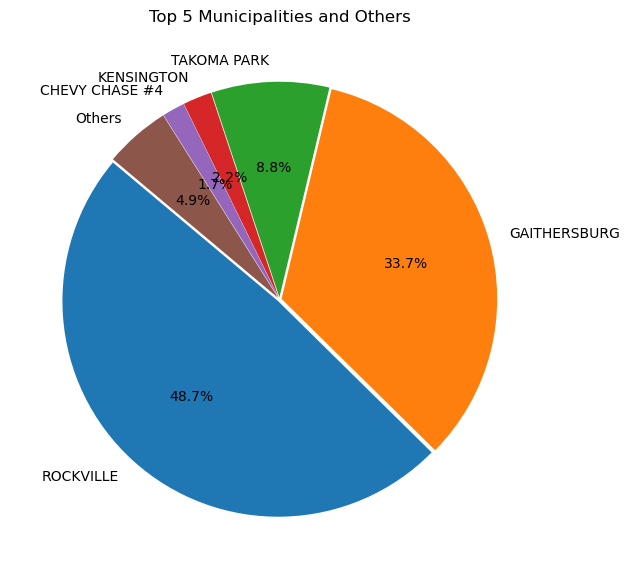

In [8]:
# Plot Pie Chart
# Calculate the top 5 and the sum of the rest
top_5 = row_counts.head(5)
others_count = row_counts.iloc[5:]['Row_Count'].sum()

# Create a DataFrame for "Others"
others = pd.DataFrame({'Municipality': ['Others'], 'Row_Count': [others_count]})

# Concatenate the top 5 with the "Others" row
top_5 = pd.concat([top_5, others], ignore_index=True)

# Plotting
labels = top_5["Municipality"]
sizes = top_5["Row_Count"]
explode = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01] # Explode the top 5 and the 'Others'

plt.figure(figsize=(10, 7))
plt.pie(sizes, autopct="%1.1f%%", labels=labels, explode=explode, startangle=140)
plt.title('Top 5 Municipalities and Others')
plt.show()

In [9]:
# break the crash date/time column to date and military time (new_column_name date & car_accident_time) => later, if necessary, we need to break it by "year"
# Split the "Crash Date/Time" column into separate date and time columns
reduced_car_crash_df[['Date', 'Time']] = reduced_car_crash_df['Crash Date/Time'].str.split(' ', expand=True, n=1)

# Convert the time to military format
reduced_car_crash_df['Time'] = pd.to_datetime(reduced_car_crash_df['Time'], format='%I:%M:%S %p').dt.strftime('%H:%M:%S')

# Drop the original "Crash Date/Time" and "Time" columns if needed
reduced_car_crash_df.drop(columns=['Crash Date/Time'], inplace=True)

reduced_car_crash_df['Date'] = pd.to_datetime(reduced_car_crash_df['Date'], format='%m/%d/%Y')
reduced_car_crash_df['Year'] = reduced_car_crash_df['Date'].dt.year
reduced_car_crash_df['Month'] = reduced_car_crash_df['Date'].dt.month
reduced_car_crash_df['Day'] = reduced_car_crash_df['Date'].dt.day

reduced_car_crash_df

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
41,EJ78850036,Municipality,FIRSTFIELD RD,QUINCE ORCHARD BLVD,STRAIGHT MOVEMENT ANGLE,GAITHERSBURG,CLEAR,DRY,STOP SIGN,30,39.141990,-77.224371,2023-07-20,14:48:00,2023,7,20
50,MCP3161005H,Maryland (State),BRADLEY LA,WEST AVE,SAME DIR REAR END,CHEVY CHASE #4,CLEAR,DRY,NO CONTROLS,25,38.977186,-77.088324,2023-07-27,16:14:00,2023,7,27
51,DM8476004Z,Maryland (State),NEW HAMPSHIRE AVE,HOLTON LA,SAME DIRECTION RIGHT TURN,TAKOMA PARK,CLEAR,DRY,NaN,35,38.985947,-76.988159,2023-07-22,17:10:00,2023,7,22
52,EJ78940034,Municipality,W DEER PARK RD,CEDAR AVE,SAME DIR REAR END,GAITHERSBURG,CLEAR,DRY,NO CONTROLS,25,39.133463,-77.203386,2023-07-15,10:47:00,2023,7,15
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172088,DD5508002B,Municipality,S STONESTREET AVE,READING TERR,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,NaN,25,39.085408,-77.144982,2016-09-12,18:08:00,2016,9,12
172091,DD5649002Q,Municipality,TWINBROOK PKWY,MCAULIFFE DR,SINGLE VEHICLE,ROCKVILLE,CLEAR,DRY,NO CONTROLS,25,39.074504,-77.111280,2022-11-11,02:40:00,2022,11,11
172099,DD56230016,Municipality,BROADWOOD DR,GRANDIN AVE,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,STOP SIGN,25,39.077970,-77.122989,2018-03-25,14:10:00,2018,3,25
172100,DM8338000C,Municipality,NEW HAMPSHIRE SERVICE LA,PRINCE GEORGES AVE,OTHER,TAKOMA PARK,CLEAR,DRY,NaN,25,38.972560,-76.997466,2016-03-01,10:01:00,2016,3,1


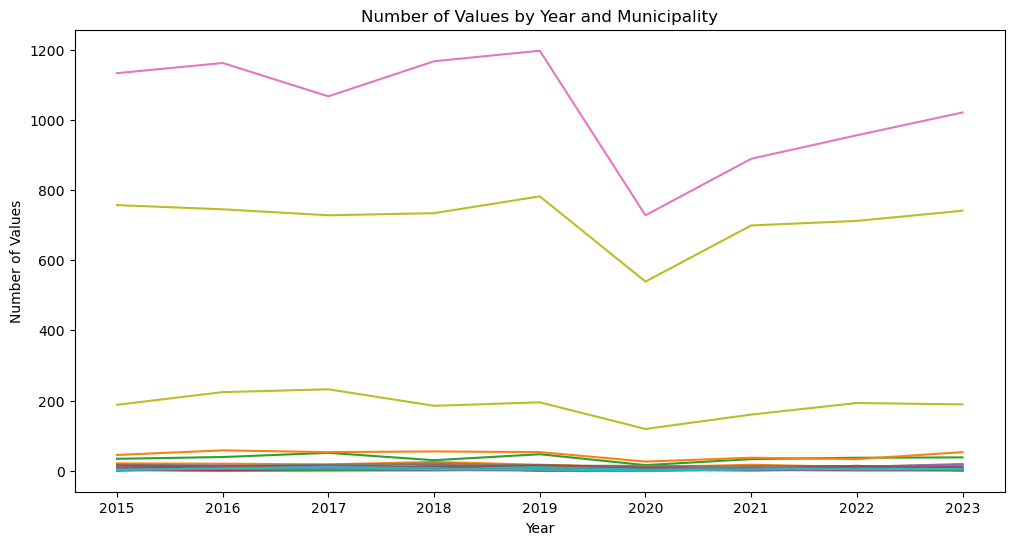

In [10]:
df = reduced_car_crash_df.groupby(['Year', 'Municipality']).size().reset_index(name='Count')

pivot_df = df.pivot(index='Year', columns='Municipality', values='Count').fillna(0)
pivot_df
# Plotting
plt.figure(figsize=(12, 6))

for municipality in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[municipality], label=municipality)

plt.xlabel('Year')
plt.ylabel('Number of Values')
plt.title('Number of Values by Year and Municipality')
plt.show()

In [11]:
rock_df = reduced_car_crash_df[reduced_car_crash_df['Municipality'] == "ROCKVILLE"]
rock_df

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
63,MCP25520068,Maryland (State),FREDERICK RD,RIDGEMONT AVE,HEAD ON LEFT TURN,ROCKVILLE,CLEAR,WET,TRAFFIC SIGNAL,35,39.119066,-77.171987,2023-07-25,21:57:00,2023,7,25
66,DD5652003G,Maryland (State),NORBECK RD,AVERY RD,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,50,39.093226,-77.122113,2023-07-21,14:26:00,2023,7,21
88,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,30,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
91,DD55830085,Maryland (State),HUNGERFORD DR,MANNAKEE ST,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,35,39.096320,-77.153139,2023-07-24,10:52:00,2023,7,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172087,DD5649000V,Municipality,ROLLINS AVE,MARTHA TERR,SAME DIR REAR END,ROCKVILLE,NaN,DRY,STOP SIGN,25,39.057302,-77.133702,2021-08-19,15:50:00,2021,8,19
172088,DD5508002B,Municipality,S STONESTREET AVE,READING TERR,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,NaN,25,39.085408,-77.144982,2016-09-12,18:08:00,2016,9,12
172091,DD5649002Q,Municipality,TWINBROOK PKWY,MCAULIFFE DR,SINGLE VEHICLE,ROCKVILLE,CLEAR,DRY,NO CONTROLS,25,39.074504,-77.111280,2022-11-11,02:40:00,2022,11,11
172099,DD56230016,Municipality,BROADWOOD DR,GRANDIN AVE,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,STOP SIGN,25,39.077970,-77.122989,2018-03-25,14:10:00,2018,3,25


In [12]:
map_plot_rock = rock_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Municipality"
)
map_plot_rock

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Municipality)

In [15]:
rock_df["Road Name"].unique()

array(['ROCKVILLE PIKE', 'FREDERICK RD', 'NORBECK RD', 'HUNGERFORD DR',
       'W JEFFERSON ST', 'EDMONSTON DR', 'N WASHINGTON ST',
       'VEIRS MILL RD', 'PRETTYMAN DR', 'E GUDE DR', 'E MONTGOMERY AVE',
       'W MONTGOMERY AVE', 'TWINBROOK PKWY', 'CHAPMAN AVE', 'FIRST ST',
       'MONTROSE RD', 'JEFFERSON PLAZA', 'N HORNERS LA', 'WOOTTON PKWY',
       'GAITHER RD', 'SHADY GROVE RD', 'S STONESTREET AVE', 'CRABB AVE',
       'DOUGLAS AVE', 'SPRING AVE', 'FALLSGROVE BLVD', 'W GUDE DR',
       'SEVEN LOCKS RD', 'N STONESTREET AVE', 'KERSEY LA', 'MARYLAND AVE',
       'REDLAND BLVD', 'LONGWOOD DR', 'FALLS RD', 'LEWIS AVE',
       'E JEFFERSON ST', 'FLEET ST', 'PICCARD DR', 'STRATTON DR',
       'MANNAKEE ST', 'ROTHGEB DR', 'PARK RD', 'ROLLINS AVE',
       'FARM HAVEN DR', 'ORCHARD WAY S', 'BLACKWELL RD', 'BEALL AVE #2',
       'SOUTHLAWN LA', 'MASON DR', 'WOODBURN RD', 'RESEARCH BLVD',
       'DENHAM RD', 'SADDLE RIDGE LA', 'AZALEA DR', 'READING AVE',
       'WADE AVE', 'MONROE ST', 'ELM

In [16]:
filtered_df = rock_df[rock_df["Road Name"] == "ROCKVILLE PIKE"]
filtered_df

,Report Number,Route Type,Road Name,Cross-Street Name,Collision Type,Municipality,Weather,Surface Condition,Traffic Control,Speed Limit,Latitude,Longitude,Date,Time,Year,Month,Day
62,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,40,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
88,DD56700006,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,NaN,DRY,TRAFFIC SIGNAL,30,39.074431,-77.135645,2023-07-22,04:07:00,2023,7,22
317,DD561500FH,Maryland (State),ROCKVILLE PIKE,RICHARD MONTGOMERY DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,25,39.083840,-77.153118,2023-07-25,15:20:00,2023,7,25
318,DD561500FH,Maryland (State),ROCKVILLE PIKE,RICHARD MONTGOMERY DR,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,TRAFFIC SIGNAL,35,39.083840,-77.153118,2023-07-25,15:20:00,2023,7,25
702,DD559500DS,Maryland (State),ROCKVILLE PIKE,MT VERNON PL,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLOUDY,DRY,STOP SIGN,25,39.078854,-77.142090,2023-08-05,12:15:00,2023,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171523,DD56040021,Maryland (State),ROCKVILLE PIKE,W EDMONSTON DR,HEAD ON LEFT TURN,ROCKVILLE,RAINING,WET,FLASHING TRAFFIC SIGNAL,40,39.074172,-77.135990,2018-06-21,01:09:00,2018,6,21
171563,DD56160017,Maryland (State),ROCKVILLE PIKE,WOOTTON PKWY,STRAIGHT MOVEMENT ANGLE,ROCKVILLE,CLEAR,DRY,NO CONTROLS,40,39.077655,-77.140540,2016-08-14,18:22:00,2016,8,14
171604,MCP2726001H,Maryland (State),ROCKVILLE PIKE,THOMPSON AVE,SAME DIR REAR END,ROCKVILLE,CLEAR,DRY,NO CONTROLS,40,39.059275,-77.121685,2016-09-27,12:41:00,2016,9,27
171864,MCP2160002L,Maryland (State),ROCKVILLE PIKE,EDMONSTON DR,SAME DIRECTION SIDESWIPE,ROCKVILLE,CLEAR,DRY,NaN,35,39.071888,-77.132846,2023-03-04,17:54:00,2023,3,4


In [14]:
# reduced_car_crash_df in order of most car accidents to see trends for each year (must have 5 lines in one line chart)
# decide which municipality has the most car accident increase in the past 3 years
df = reduced_car_crash_df.groupby(["Year","Municipality"]).count()
x_axis = df['Year']
y_axis = df['Report Number']
labels = df['Municipality']
plt.plot(x_axis, y_axis)
# plt.plot(x_axis_data, points_C)
# plt.show()

KeyError: 'Year'

In [ ]:
# with the chosen Municipality, we can identify what road has the most accident

In [ ]:
# we can also see what time has the most accidents

In [17]:
# map plot to search where the most car accident happened (with the chosen Municipality)
map_plot_1 = df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    color = "Municipality"
)
map_plot_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Municipality)